## Importação dos dados

# Viral Tweet Prediction Challenge - Grupo Sparkanos
#### Andrey Inácio Paulino
#### Eduardo Almeida M Neiva
#### Gabriel Victor de Jesus Lima
#### Luiz Claudio Olivato
#### Vitor Pinho Iecks Ponce

Publicação de referência do código https://towardsdatascience.com/using-data-science-to-predict-viral-tweets-615b0acc2e1e. Autor: Benedict Neo

As principais diferenças entre nosso código e o do site são:

- Utilizamos Informação Mútua para a seleção de variáveis, o código 
original utiliza *SelectFromModel* a partir de uma regressão Logística;

- Não fizemos a transformação da hora para seno e cosseno;
- Não criamos dummies para as contagens de hashtag, mentions e url. Ao invés, padronizamos essas variáveis.
- Padronizamos dados relativos aos usuários como número de seguidores, likes, tweets, etc.
- Usamos o modelo Adaboost no lugar do classificador LGBM e também fizemos um tunning de hiperparâmetros usando Grid Search.


In [ ]:
#bibliotecas
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
tweets_path = r'gdrive/MyDrive/datasets/Dataset/Tweets'
users_path = r'gdrive/MyDrive/datasets/Dataset/Users'

# Load training datasets
train_tweets = pd.read_csv(tweets_path + '/train_tweets.csv')
train_tweets_vectorized_media = pd.read_csv(tweets_path + '/train_tweets_vectorized_media.csv')     
train_tweets_vectorized_text = pd.read_csv(tweets_path + '/train_tweets_vectorized_text.csv')       
                                                                                                      
# Load user dataset
users = pd.read_csv(users_path + '/users.csv')
user_vectorized_descriptions = pd.read_csv(users_path + '/user_vectorized_descriptions.csv')
user_vectorized_profile_images = pd.read_csv(users_path + '/user_vectorized_profile_images.csv')

In [ ]:
train_tweets.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality
0,34698,10,2015,12,5,3,2.0,1.0,0.0,False,C,0,"['36', '36', '36', '36', '36', '36', '37', '37...",3
1,24644,4,2020,6,19,0,0.0,1.0,0.0,False,C,0,"['43', '78', '79', '80', '80', '89', '98', '99...",3
2,36321,54,2019,6,2,15,2.0,3.0,0.0,True,A,0,"['79', '80', '98', '98', '98', '99', '99', '10...",1
3,2629,42,2020,9,6,17,0.0,1.0,1.0,True,A,0,"['43', '79', '80', '98', '99', '99', '79', '80']",2
4,28169,32,2020,11,4,17,2.0,1.0,0.0,True,A,0,"['79', '80', '98', '99', '43', '89']",2


In [ ]:
train_tweets_vectorized_media.head()

,media_id,tweet_id,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,img_feature_8,img_feature_9,img_feature_10,img_feature_11,img_feature_12,img_feature_13,img_feature_14,img_feature_15,img_feature_16,img_feature_17,img_feature_18,img_feature_19,img_feature_20,img_feature_21,img_feature_22,img_feature_23,img_feature_24,img_feature_25,img_feature_26,img_feature_27,img_feature_28,img_feature_29,img_feature_30,img_feature_31,img_feature_32,img_feature_33,img_feature_34,img_feature_35,img_feature_36,img_feature_37,...,img_feature_2008,img_feature_2009,img_feature_2010,img_feature_2011,img_feature_2012,img_feature_2013,img_feature_2014,img_feature_2015,img_feature_2016,img_feature_2017,img_feature_2018,img_feature_2019,img_feature_2020,img_feature_2021,img_feature_2022,img_feature_2023,img_feature_2024,img_feature_2025,img_feature_2026,img_feature_2027,img_feature_2028,img_feature_2029,img_feature_2030,img_feature_2031,img_feature_2032,img_feature_2033,img_feature_2034,img_feature_2035,img_feature_2036,img_feature_2037,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
0,00001_00000,1,0.290614,0.150803,0.008313,0.040887,0.0,0.000000,0.214209,0.000792,0.00027,0.424207,0.000000,0.372124,0.031332,0.041069,0.000000,0.209875,0.232068,0.003567,0.185193,0.096734,0.127461,0.005552,0.000435,0.429719,0.024739,0.000051,0.000842,0.115226,0.000000,0.026856,0.000000,0.031253,0.032772,0.051137,0.026097,0.962891,0.132004,0.158875,...,0.000480,0.000000,0.018373,0.327092,0.079089,0.360097,0.002562,1.116611,0.054391,0.086378,0.045496,0.030632,0.000000,0.000000,0.000000,0.165220,0.000000,0.059310,0.111803,0.000000,0.109110,0.025834,0.235375,0.078341,0.131708,0.013988,0.000000,0.025960,0.015760,0.266088,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
1,00004_00003,4,0.038251,0.036437,0.000000,0.015076,0.0,0.046953,0.648170,0.026476,0.00000,0.191951,0.003372,0.000000,0.009363,0.000000,0.000000,0.012317,0.016527,0.130308,0.000000,0.000000,0.303246,0.000000,0.307988,0.011478,0.044807,0.208410,0.043399,0.118079,0.000222,0.083115,0.000000,0.634716,0.000000,0.014040,0.090266,0.000000,0.127964,0.189758,...,0.000000,0.001796,0.000000,0.251383,0.021052,0.802314,0.027913,0.335493,0.017326,0.000000,0.026515,0.056399,0.030597,0.082174,0.003829,0.083139,0.003266,0.249968,0.304901,0.004793,0.028569,0.000000,0.069980,0.007251,0.194076,0.000000,0.124188,0.000000,0.691953,0.009337,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
2,00005_00004,5,0.506981,0.305467,0.036150,0.114539,0.0,0.146888,0.584753,0.157468,0.00000,0.040884,0.009688,0.000000,0.000000,0.000000,0.074692,0.018211,0.233618,0.039807,0.000000,0.000000,0.169830,0.000000,0.045755,0.028518,0.000000,0.259838,0.117726,0.017544,0.018106,0.000000,0.019969,0.257562,0.000000,0.006338,0.000000,0.000000,0.090963,0.746206,...,0.000000,0.000000,0.032314,0.000000,0.000000,0.143607,0.371495,0.199860,0.192786,0.000000,0.401853,0.021595,0.033472,0.164238,0.085964,0.293521,0.000000,0.082590,0.020819,0.001283,0.009182,0.000000,0.295073,0.000000,0.300424,0.228981,0.109332,0.032641,0.263165,0.000992,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
3,00008_00007,8,0.000000,0.242857,0.000000,0.068217,0.0,0.117847,0.000000,0.000000,0.00000,0.040679,0.027965,0.000000,0.001766,0.014541,0.000000,0.010728,0.147126,0.574918,0.000000,0.126482,0.096826,0.040340,0.005732,0.000296,0.000000,0.081848,0.000000,0.001031,0.114108,0.000000,0.000000,0.702560,0.000000,0.307037,0.290887,0.003196,0.093841,0.257387,...,0.214097,0.000000,0.004700,0.005008,0.000000,0.540658,0.035425,0.069549,0.197432,0.023377,0.010510,0.000000,0.023421,0.000000,0.029902,0.067589,0.080281,0.005246,0.000000,0.000000,0.007966,0.000000,0.064383,0.255950,0.330105,0.000000

In [ ]:
train_tweets_vectorized_text.head()

,tweet_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,...,feature_728,feature_729,feature_730,feature_731,feature_732,feature_733,feature_734,feature_735,feature_736,feature_737,feature_738,feature_739,feature_740,feature_741,feature_742,feature_743,feature_744,feature_745,feature_746,feature_747,feature_748,feature_749,feature_750,feature_751,feature_752,feature_753,feature_754,feature_755,feature_756,feature_757,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,0.120231,-0.245443,0.199461,-0.154236,-0.200109,-0.206436,0.270252,-0.142692,-0.102078,0.157226,-0.334515,-0.264958,-0.112983,-0.293211,-0.253694,-0.104198,0.056506,-0.231244,0.152571,0.206752,-0.150545,0.112063,-0.129411,-0.224150,-0.175330,-0.165828,-0.066047,-0.159027,0.009872,0.019299,...,0.039782,-0.174679,0.148821,-0.192575,-0.114211,0.496451,0.040274,-0.142680,0.169754,-0.075535,-0.117306,0.261488,0.240786,-0.150380,-0.080656,0.310319,0.042854,0.048131,-0.172710,0.135926,-0.043390,-0.208796,0.040137,-0.190645,-0.096934,-0.009036,0.284776,0.338148,-0.440536,-0.090837,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,0.135007,-0.192705,0.252616,-0.135662,-0.201412,-0.183382,0.173640,-0.103182,-0.074723,0.234004,-0.283560,-0.120644,-0.063076,-0.248546,-0.224326,-0.176795,0.061400,-0.243843,0.226394,0.101096,-0.077593,0.057844,-0.086949,-0.239860,-0.303655,-0.223538,-0.041548,-0.162694,0.005842,0.053615,...,0.151876,-0.153876,0.272216,-0.265888,-0.124845,0.500886,-0.053478,-0.159796,0.102271,0.032116,-0.034348,0.292187,0.236578,-0.006660,-0.113676,0.249192,0.048188,-0.055551,-0.037698,0.148909,0.064823,-0.270230,0.003926,-0.207080,-0.062248,-0.056531,0.188629,0.366379,-0.511710,-0.025049,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,0.101362,-0.238145,0.173951,-0.102029,-0.181864,-0.214877,0.186110,-0.032114,-0.143620,0.175421,-0.260034,-0.103828,-0.122353,-0.316970,-0.289015,-0.215771,0.027695,-0.254362,0.160985,0.040491,-0.019251,0.156431,-0.089619,-0.204530,-0.155480,-0.207329,-0.044228,-0.094432,-0.054102,-0.069460,...,0.013487,-0.145385,0.251336,-0.243751,-0.218401,0.557650,-0.032927,-0.233999,0.107764,-0.054706,-0.151404,0.268172,0.148024,0.066601,-0.126532,0.235418,0.013908,0.107383,-0.114999,0.242328,0.062410,-0.122995,0.026454,-0.118704,-0.025266,0.015129,0.252958,0.273657,-0.522295,-0.049114,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,0.056506,-0.180725,0.183492,-0.055121,-0.205312,-0.267817,0.152828,-0.026461,-0.150457,0.253863,-0.289086,-0.194721,-0.073793,-0.313012,-0.311311,-0.254014,-0.055075,-0.147885,0.179036,0.120235,-0.005531,0.080192,-0.229052,-0.137060,-0.281633,-0.225555,-0.010621,-0.105480,-0.135987,-0.034342,...,0.058002,-0.146499,0.203021,-0.242434,-0.169852,0.488979,0.018102,-0.178110,0.155078,-0.020591,-0.145490,0.284350,0.186599,0.037712,-0.143745,0.180907,-0.023579,0.016043,-0.097705,0.168376,0.072525,-0.184797,0.048695,-0.136387,-0.102923,-0.042237,0.235340,0.317434,-0.532257,-0.036280,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084

## Análise Exploratória 

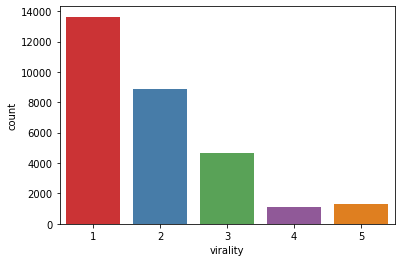

In [ ]:
sns.countplot(x = 'virality', data = train_tweets, palette="Set1");

In [ ]:
train_tweets.groupby('virality')['tweet_created_at_day'].describe()

,count,mean,std,min,25%,50%,75%,max
virality,,,,,,,,
1,13632.0,15.743765,8.894090,1.0,8.0,16.0,23.0,31.0
2,8889.0,15.678592,8.820561,1.0,8.0,15.0,23.0,31.0
3,4646.0,16.079423,8.921035,1.0,8.0,16.0,24.0,31.0
4,1135.0,15.878414,8.852865,1.0,8.0,16.0,24.0,31.0
5,1323.0,16.476190,8.819162,1.0,9.0,17.0,24.0,31.0


Todos os níveis de viralidade tem distribuição similar: uniforme ao longo do mês.

In [ ]:
train_tweets.groupby('virality')['tweet_created_at_hour'].describe()

,count,mean,std,min,25%,50%,75%,max
virality,,,,,,,,
1,13632.0,15.063013,4.955831,0.0,13.0,16.0,18.0,23.0
2,8889.0,15.356846,5.298133,0.0,14.0,16.0,19.0,23.0
3,4646.0,14.618166,5.252518,0.0,12.0,16.0,18.0,23.0
4,1135.0,14.784141,5.471436,0.0,13.0,16.0,18.0,23.0
5,1323.0,14.559335,6.097549,0.0,13.0,16.0,19.0,23.0


A variabilidade cresce conforme o nível de viralidade, mas as diferenças são pequenas.

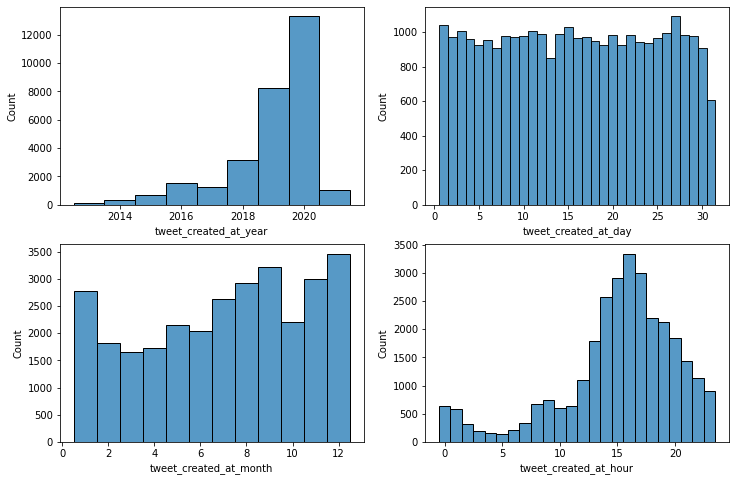

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(train_tweets, x = 'tweet_created_at_year', discrete = True, ax = axs[0,0]);
sns.histplot(train_tweets, x = 'tweet_created_at_day', discrete = True, ax = axs[0,1]);
sns.histplot(train_tweets, x = 'tweet_created_at_month', discrete = True, ax = axs[1,0]);
sns.histplot(train_tweets, x = 'tweet_created_at_hour', discrete = True, ax = axs[1,1]);

Observa-se que a maioria dos tweets são do ano 2020. A distribuição de tweets por dia do mês é uniforme, assim como a de tweets por mês. Já para o horário, a maioria dos tweets é postado entre o fim da tarde e começo da noite.

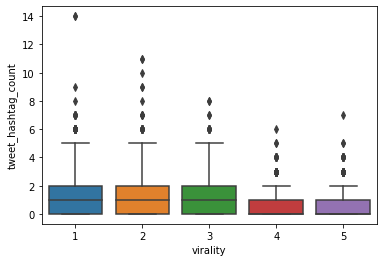

In [ ]:
sns.boxplot(x='virality', y='tweet_hashtag_count', data=train_tweets)

Nota-se que os 3 primeiros níveis tem distribuição muita similar mas os últimos dois níveis tiveram mediana mais baixa (0 vs 1) e limite superior também mais baixo (2 vs 5), sugerindo que tweets virais tem menos hashtags no geral.

Como o dataset tem mais de 29 mil linhas, esses resultados possuem alguma significância.

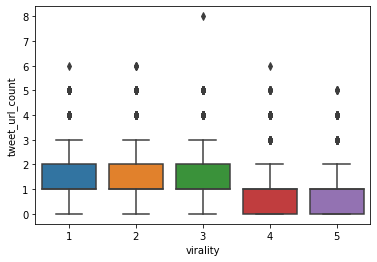

In [ ]:
sns.boxplot(x='virality', y='tweet_url_count', data=train_tweets)

Mesma interpetação que o anterior: tweets virais tem números mais baixos de url.

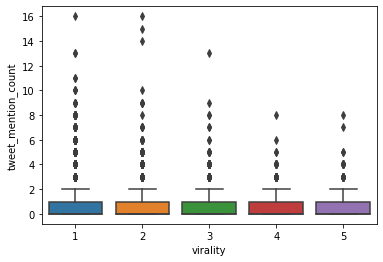

In [ ]:
sns.boxplot(x='virality', y='tweet_mention_count', data=train_tweets)

Nenhuma diferença observada exceto pelo número de outliers, o que não é surpresa.

Função de auxílio para localizar dados faltantes

In [ ]:
def missing_cols(df):
    '''prints out columns with its amount of missing values with its %'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        pct = df[col].isna().mean() * 100
        total += missing_vals
        if missing_vals != 0:
          print('{} => {} [{}%]'.format(col, df[col].isnull().sum(), round(pct, 2)))
    
    if total == 0:
        print("no missing values")

In [ ]:
missing_cols(train_tweets);
missing_cols(users);
missing_cols(train_tweets_vectorized_media);
missing_cols(train_tweets_vectorized_text)

tweet_topic_ids => 4285 [14.46%]
no missing values
no missing values
no missing values



Apenas a coluna topic_ids de train_tweets tem dados faltando.



## Pré Processamento


Substitui os dados faltantes dos tópicos por um vetor de zeros.

In [ ]:
train_tweets.fillna({'tweet_topic_ids':"['0']"}, inplace=True) # substitui por um vetor nulo
missing_cols(train_tweets) # verifica se ainda há dados faltando

no missing values


Cria dummies para os tópicos dos tweets, tipo de attachment, idioma, ano, mês, dia e hora do tweet (variáveis categóricas). Padroniza as variáveis numéricas (quantidad de url, menções e hashtags).

In [ ]:
topic_ids = (
    train_tweets['tweet_topic_ids'].str.strip('[]').str.split('\s*,\s*').explode()
    .str.get_dummies().sum(level=0).add_prefix('topic_id_') 
) 
topic_ids.rename(columns = lambda x: x.replace("'", ""), inplace=True)

In [ ]:
year  = pd.get_dummies(train_tweets.tweet_created_at_year, prefix='year')
month = pd.get_dummies(train_tweets.tweet_created_at_month , prefix='month')
day = pd.get_dummies(train_tweets.tweet_created_at_day, prefix='day')
hour = pd.get_dummies(train_tweets.tweet_created_at_hour, prefix='hour')
attachment = pd.get_dummies(train_tweets.tweet_attachment_class, prefix='attatchment')
language = pd.get_dummies(train_tweets.tweet_language_id, prefix='language')

In [ ]:
sc_train= StandardScaler()

aux = train_tweets.iloc[:,6:9] #hashtag_count, url_count e mention_count serão padronizadas
aux= sc_train.fit_transform(aux)

columns_drop = [
                "tweet_topic_ids",
                "tweet_created_at_year",
                "tweet_created_at_month",
                "tweet_created_at_day",
                "tweet_attachment_class",
                "tweet_language_id",
                "tweet_created_at_hour",
                "tweet_url_count",
                "tweet_mention_count",
                "tweet_hashtag_count"
               ]
aux=pd.DataFrame(aux)

dfs = [topic_ids,attachment,language, hour, day, month,year,aux]

train_tweets_final = train_tweets.drop(columns_drop, 1).join(dfs)

In [ ]:
train_tweets_final.rename(columns={0: 'hashtag_count', 1: 'url_count', 2: 'mention_count'}, inplace=True)

In [ ]:
train_tweets_final.head() 

,tweet_id,tweet_user_id,tweet_has_attachment,virality,topic_id_0,topic_id_100,topic_id_101,topic_id_104,topic_id_111,topic_id_112,topic_id_118,topic_id_119,topic_id_120,topic_id_121,topic_id_122,topic_id_125,topic_id_126,topic_id_127,topic_id_147,topic_id_148,topic_id_149,topic_id_150,topic_id_151,topic_id_152,topic_id_153,topic_id_155,topic_id_156,topic_id_163,topic_id_165,topic_id_169,topic_id_170,topic_id_171,topic_id_172,topic_id_36,topic_id_37,topic_id_39,topic_id_43,topic_id_44,topic_id_45,topic_id_52,...,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,hashtag_count,url_count,mention_count
0,34698,10,False,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.839947,-0.222227,-0.634174
1,24644,4,False,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.935856,-0.222227,-0.634174
2,36321,54,True,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.839947,1.808142,-0.634174
3,2629,42,True,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-0.935856,-0.222227,0.354741
4,28169,32,True,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.839947,-0.222227,-0.634174


Cria dummies para o conjunto de usuários e padroniza as variáveis numéricas contagem de tweets, likes, seguidores e 'listed_on'.

In [ ]:
year = pd.get_dummies(users.user_created_at_year, prefix='year')
month = pd.get_dummies(users.user_created_at_month , prefix='month')
user_verified = pd.get_dummies(users.user_verified, prefix='verified')

In [ ]:
aux=users.loc[:,['user_like_count','user_followers_count','user_listed_on_count','user_tweet_count']] #varáveis a serem padronizadas
cols=aux.columns

sc_users=StandardScaler()

aux=sc_users.fit_transform(aux)
aux=pd.DataFrame(aux)
aux.columns=cols

columns_drop = [
                "user_created_at_year",
                "user_created_at_month",
                "user_verified",
                'user_like_count',
                'user_followers_count',
                'user_listed_on_count',
                'user_tweet_count'
              ]

dfs = [
        year,
        month,
        user_verified,
        aux
      ]

users_final = users.drop(columns_drop, 1).join(dfs)

users_final.head()

,user_id,user_following_count,user_has_location,user_has_url,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,month_1,month_2,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,verified_0,verified_1,user_like_count,user_followers_count,user_listed_on_count,user_tweet_count
0,0,70469,True,True,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,-0.620195,-0.536719,-0.122395,-0.330961
1,1,2171,False,False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,-0.134269,-0.436668,-0.124075,-0.424784
2,2,1416,True,True,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.639326,-0.121060,0.190645,0.577329
3,3,4572,True,True,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,-0.513115,-0.627743,-0.650805,-0.355277
4,4,1021,False,False,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1.879587,0.583807,0.060029,1.071106


## Feature Selection - Mutual Information

Junta os datasets train_tweets e vectorized_media para aplicar feature selection. A primeira linha do código acrescenta todas as colunas de train_tweet aos dados de mídia de acordo com o ID, para que apenas os tweets que possuem mídia receberem a coluna de viralidade. O método ***difference*** garante que apenas a coluna virality irá permancer nos dados de mídia.

In [ ]:
vectorized_media_df = pd.merge(train_tweets,train_tweets_vectorized_media, on ='tweet_id', how = 'right')
vectorized_media_df.drop(train_tweets.columns.difference(['virality']), axis=1, inplace=True)
vectorized_media_df.head()

,virality,media_id,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,img_feature_8,img_feature_9,img_feature_10,img_feature_11,img_feature_12,img_feature_13,img_feature_14,img_feature_15,img_feature_16,img_feature_17,img_feature_18,img_feature_19,img_feature_20,img_feature_21,img_feature_22,img_feature_23,img_feature_24,img_feature_25,img_feature_26,img_feature_27,img_feature_28,img_feature_29,img_feature_30,img_feature_31,img_feature_32,img_feature_33,img_feature_34,img_feature_35,img_feature_36,img_feature_37,...,img_feature_2008,img_feature_2009,img_feature_2010,img_feature_2011,img_feature_2012,img_feature_2013,img_feature_2014,img_feature_2015,img_feature_2016,img_feature_2017,img_feature_2018,img_feature_2019,img_feature_2020,img_feature_2021,img_feature_2022,img_feature_2023,img_feature_2024,img_feature_2025,img_feature_2026,img_feature_2027,img_feature_2028,img_feature_2029,img_feature_2030,img_feature_2031,img_feature_2032,img_feature_2033,img_feature_2034,img_feature_2035,img_feature_2036,img_feature_2037,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
0,1,00001_00000,0.290614,0.150803,0.008313,0.040887,0.0,0.000000,0.214209,0.000792,0.00027,0.424207,0.000000,0.372124,0.031332,0.041069,0.000000,0.209875,0.232068,0.003567,0.185193,0.096734,0.127461,0.005552,0.000435,0.429719,0.024739,0.000051,0.000842,0.115226,0.000000,0.026856,0.000000,0.031253,0.032772,0.051137,0.026097,0.962891,0.132004,0.158875,...,0.000480,0.000000,0.018373,0.327092,0.079089,0.360097,0.002562,1.116611,0.054391,0.086378,0.045496,0.030632,0.000000,0.000000,0.000000,0.165220,0.000000,0.059310,0.111803,0.000000,0.109110,0.025834,0.235375,0.078341,0.131708,0.013988,0.000000,0.025960,0.015760,0.266088,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
1,2,00004_00003,0.038251,0.036437,0.000000,0.015076,0.0,0.046953,0.648170,0.026476,0.00000,0.191951,0.003372,0.000000,0.009363,0.000000,0.000000,0.012317,0.016527,0.130308,0.000000,0.000000,0.303246,0.000000,0.307988,0.011478,0.044807,0.208410,0.043399,0.118079,0.000222,0.083115,0.000000,0.634716,0.000000,0.014040,0.090266,0.000000,0.127964,0.189758,...,0.000000,0.001796,0.000000,0.251383,0.021052,0.802314,0.027913,0.335493,0.017326,0.000000,0.026515,0.056399,0.030597,0.082174,0.003829,0.083139,0.003266,0.249968,0.304901,0.004793,0.028569,0.000000,0.069980,0.007251,0.194076,0.000000,0.124188,0.000000,0.691953,0.009337,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
2,1,00005_00004,0.506981,0.305467,0.036150,0.114539,0.0,0.146888,0.584753,0.157468,0.00000,0.040884,0.009688,0.000000,0.000000,0.000000,0.074692,0.018211,0.233618,0.039807,0.000000,0.000000,0.169830,0.000000,0.045755,0.028518,0.000000,0.259838,0.117726,0.017544,0.018106,0.000000,0.019969,0.257562,0.000000,0.006338,0.000000,0.000000,0.090963,0.746206,...,0.000000,0.000000,0.032314,0.000000,0.000000,0.143607,0.371495,0.199860,0.192786,0.000000,0.401853,0.021595,0.033472,0.164238,0.085964,0.293521,0.000000,0.082590,0.020819,0.001283,0.009182,0.000000,0.295073,0.000000,0.300424,0.228981,0.109332,0.032641,0.263165,0.000992,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
3,1,00008_00007,0.000000,0.242857,0.000000,0.068217,0.0,0.117847,0.000000,0.000000,0.00000,0.040679,0.027965,0.000000,0.001766,0.014541,0.000000,0.010728,0.147126,0.574918,0.000000,0.126482,0.096826,0.040340,0.005732,0.000296,0.000000,0.081848,0.000000,0.001031,0.114108,0.000000,0.000000,0.702560,0.000000,0.307037,0.290887,0.003196,0.093841,0.257387,...,0.214097,0.000000,0.004700,0.005008,0.000000,0.540658,0.035425,0.069549,0.197432,0.023377,0.010510,0.000000,0.023421,0.000000,0.029902,0.067589,0.080281,0.005246,0.000000,0.000000,0.007966,0.000000,0.064383,0.255950,0.330105,0.000000

In [ ]:
y = vectorized_media_df['virality']
x = vectorized_media_df.loc[:, vectorized_media_df.columns.str.contains("img_")]  #seleciona apenas dados relativos à mídia.

In [ ]:
scores=mutual_info_classif(x,y, discrete_features='auto', n_neighbors=3, copy=True, random_state=10)

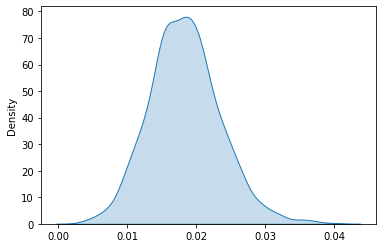

In [ ]:
sns.kdeplot(scores, shade=True)

Nota-se que os valores foram baixos. Iremos utilizar apenas as variáveis cujo score foi de ao menos 0,025.



In [ ]:
aux=scores>=0.025

O código abaixo recebe a máscara ***aux*** para selecionar as variáveis de x que foram consideradas signficativas, em seguida, junta-se essas variáveis aos id's de mídia e de tweet.

In [ ]:
media_ind_df = pd.DataFrame(x[x.columns[(aux)]])
train_tweets_media_final = pd.concat([train_tweets_vectorized_media[['media_id', 'tweet_id']], media_ind_df], axis=1)
train_tweets_media_final.head()


,media_id,tweet_id,img_feature_12,img_feature_17,img_feature_29,img_feature_31,img_feature_68,img_feature_72,img_feature_98,img_feature_106,img_feature_118,img_feature_124,img_feature_131,img_feature_152,img_feature_153,img_feature_179,img_feature_182,img_feature_194,img_feature_206,img_feature_214,img_feature_221,img_feature_230,img_feature_231,img_feature_245,img_feature_253,img_feature_260,img_feature_280,img_feature_296,img_feature_301,img_feature_312,img_feature_314,img_feature_323,img_feature_327,img_feature_356,img_feature_358,img_feature_379,img_feature_381,img_feature_384,img_feature_391,img_feature_398,...,img_feature_1596,img_feature_1598,img_feature_1599,img_feature_1615,img_feature_1617,img_feature_1632,img_feature_1636,img_feature_1638,img_feature_1641,img_feature_1666,img_feature_1670,img_feature_1681,img_feature_1691,img_feature_1696,img_feature_1717,img_feature_1735,img_feature_1774,img_feature_1792,img_feature_1800,img_feature_1807,img_feature_1808,img_feature_1813,img_feature_1832,img_feature_1839,img_feature_1852,img_feature_1864,img_feature_1881,img_feature_1900,img_feature_1922,img_feature_1924,img_feature_1925,img_feature_1933,img_feature_1946,img_feature_1951,img_feature_1953,img_feature_1969,img_feature_1990,img_feature_2009,img_feature_2036,img_feature_2046
0,00001_00000,1,0.031332,0.003567,0.026856,0.031253,0.387519,0.100638,0.455933,0.001866,0.067973,0.488848,0.336947,0.464473,0.000000,0.043895,0.004400,0.484036,0.181861,0.159543,0.000000,0.137446,0.031887,0.000000,0.127859,0.218308,0.009558,0.613413,0.055532,0.427459,0.915309,0.052858,0.027840,0.119901,0.000505,0.504859,0.021801,0.041731,0.159529,0.289400,...,0.125224,0.000261,0.114567,0.197488,0.171696,0.087206,0.000000,0.04231,0.335391,0.048691,0.451014,0.038629,0.324918,0.018572,0.436671,0.377453,0.008161,0.060462,0.093105,0.009631,0.350135,0.316361,0.000000,0.562169,0.217400,0.055820,0.654456,0.000000,0.418283,0.098856,0.218709,0.092379,0.006567,0.071202,0.002819,0.071737,0.082901,0.000000,0.015760,0.383093
1,00004_00003,4,0.009363,0.130308,0.083115,0.634716,0.000000,0.876813,0.746606,0.047176,0.000000,0.237042,1.194970,0.117353,0.453411,0.000823,0.000575,0.997756,1.034455,0.003282,0.017879,0.446896,0.179325,0.009859,0.211016,1.019274,0.027114,0.726742,0.003382,0.274719,0.819286,0.000000,0.841991,0.000000,0.277779,0.333616,0.000000,0.145201,0.059869,0.283581,...,0.292239,0.085580,0.001044,0.225804,0.000000,0.001297,0.078837,0.00650,0.524708,0.140313,0.305110,0.033203,0.045001,0.021441,0.132029,0.997210,0.393198,0.266235,0.532572,0.000000,0.001048,0.456004,0.439815,0.000000,0.184206,0.508904,0.467754,0.145715,0.615333,0.206113,0.281355,0.177388,0.233710,0.379022,0.017473,0.092978,0.022655,0.001796,0.691953,0.816972
2,00005_00004,5,0.000000,0.039807,0.000000,0.257562,0.290579,0.121220,0.492950,0.053208,0.000000,0.210947,0.627089,0.000000,0.214315,0.005223,0.119169,0.436992,0.921735,0.001543,0.069951,0.000186,0.058000,0.068237,0.026912,0.318639,0.000000,0.392446,0.000000,0.658051,0.934592,0.024395,0.379586,0.000000,0.002538,0.277910,0.000000,0.092464,0.005863,0.157229,...,0.467896,0.129518,0.100477,0.047866,0.000000,0.001531,0.126281,0.00000,0.447735,0.149318,0.479830,0.000000,0.051189,0.000000,0.201439,0.732797,0.048306,0.425789,0.106194,0.000000,0.000000,0.101808,0.134185,0.000000,0.060363,0.437068,0.438740,0.223306,0.312729,0.000000,0.484823,0.273884,0.062027,0.076889,0.069678,0.632666,0.114137,0.000000,0.263165,0.123289
3,00008_00007,8,0.001766,0.574918,0.000000,0.702560,0.001484,0.122873,0.294353,0.423406,0.001247,0.018873,0.034186,0.020150,0.313297,0.000000,0.052730,0.335265,0.081215,0.271202,0.001687,0.028098,0.032460,0.000000,0.000782,0.881878,0.000000,0.580731,0.007455,0.468638,0.055886,0.000000,0.132254,0.000000,0.646682,0.785233,0.011798,0.682780,0.000097,0.313515,...,0.381575,0.006102,0.027702,0.000816,0.220610,0.129983,0.000000,0.00000,0.389350,0.162346,0.245739,0.000000,0.608172,0.000000,0.139828,0.618225,0.028275,0.103355,0.772317,0

Já para os dados de texto, não há o problema anterior e podemos apenas selecionar a coluna de viralidade de train tweets e unir com os dados de texto.

In [ ]:
y = train_tweets['virality']
x = train_tweets_vectorized_text.loc[:, train_tweets_vectorized_text.columns.str.contains("feature_")] # seleciona apenas dados relativos ao texto.

In [ ]:
scores=mutual_info_classif(x, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=10)

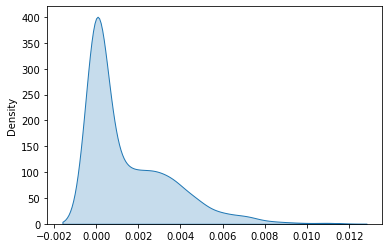

In [ ]:
sns.kdeplot(scores, shade=True)

A distribuição dos scores nesse caso foi assimétrica, além dos valores serem muito baixos. Utilizaremos as variáveis com IM de no mínimo 0.0065

In [ ]:
aux=scores>=0.0065

In [ ]:
text_ind_df = pd.DataFrame(x[x.columns[(aux)]])
train_tweets_text_final = pd.concat([train_tweets_vectorized_text[['tweet_id']], text_ind_df], axis=1)
train_tweets_text_final.head()

,tweet_id,feature_102,feature_113,feature_142,feature_145,feature_207,feature_222,feature_227,feature_249,feature_280,feature_370,feature_418,feature_419,feature_473,feature_477,feature_574,feature_669,feature_677,feature_684,feature_723,feature_724,feature_736,feature_749,feature_751
0,0,-0.221726,0.136818,-0.061068,0.158193,-0.045862,-0.013509,-0.039967,-0.314939,-0.196727,0.188231,0.120291,0.028757,-0.036622,-0.133286,-0.107766,-0.050214,-0.059973,0.067214,0.083628,-0.087576,0.169754,-0.208796,-0.190645
1,1,-0.137403,0.135520,-0.014480,0.088869,0.044203,-0.037556,-0.154202,-0.265994,-0.149688,0.177193,0.135939,-0.031836,0.002674,-0.100656,-0.087606,0.024996,-0.071726,0.097758,0.051597,-0.016395,0.102271,-0.270230,-0.207080
2,4,-0.044526,0.102074,-0.074020,0.140882,-0.033880,-0.057548,-0.129431,-0.265982,-0.210003,0.115160,0.297382,-0.069542,0.039062,-0.049084,-0.132351,-0.028518,-0.010798,0.043780,-0.059980,0.028263,0.107764,-0.122995,-0.118704
3,5,-0.139881,0.227647,-0.053799,0.054213,-0.073003,-0.122609,-0.161668,-0.342098,-0.224708,0.125567,0.219644,-0.049488,0.070556,-0.092815,0.003130,0.042733,-0.054677,0.006685,-0.001471,-0.079780,0.155078,-0.184797,-0.136387
4,8,-0.185229,0.158385,-0.071673,0.178799,0.058510,-0.152557,-0.189969,-0.274310,-0.183501,0.120061,0.201681,-0.042512,0.044605,-0.140786,-0.007107,-0.016932,-0.128080,0.112383,0.006720,-0.019072,0.161351,-0.141493,-0.116183


Um outro problema aparece aqui: precisamos obter a IM para cada descrição de usuário e imagem de perfil, porém muitos usuários tem mais de um tweet.

O código abaixo obtem a viralidade média arrendodada de cada usuário e cria data frames novos com os dados de descrição e de imagem de perfil, que possuem a viralidade média de cada usuário.

In [ ]:
average_virality_df = train_tweets.groupby('tweet_user_id').agg(pd.Series.mean)['virality']
average_virality_df = average_virality_df.round(0)
average_virality_df = average_virality_df.astype(int)

descriptions_df = pd.merge(average_virality_df, user_vectorized_descriptions, 
                           left_on ='tweet_user_id', right_on = 'user_id', how = 'right')
profile_images_df = pd.merge(average_virality_df, user_vectorized_profile_images, 
                             left_on ='tweet_user_id', right_on = 'user_id', how = 'right')

descriptions_df.head()

,virality,user_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,...,feature_728,feature_729,feature_730,feature_731,feature_732,feature_733,feature_734,feature_735,feature_736,feature_737,feature_738,feature_739,feature_740,feature_741,feature_742,feature_743,feature_744,feature_745,feature_746,feature_747,feature_748,feature_749,feature_750,feature_751,feature_752,feature_753,feature_754,feature_755,feature_756,feature_757,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,1,0,0.132536,-0.137393,-0.064037,-0.118342,-0.130279,0.048067,-0.421301,-0.313038,0.047779,0.041972,-0.211500,0.157389,-0.119609,-0.167288,-0.183701,0.162600,-0.118144,-0.160549,0.206170,-0.349808,-0.180516,-0.075424,-0.228215,-0.227588,-0.206130,0.097065,-0.201940,0.113164,0.115008,-0.025116,0.063400,-0.129166,-0.154574,-0.219841,-0.185450,-0.099904,-0.084291,-0.044961,...,0.083985,-0.157461,0.285158,-0.197924,-0.163785,0.535255,0.027747,-0.155363,0.146396,-0.090979,-0.170317,0.254166,0.260563,-0.071186,-0.140582,0.310176,0.083907,-0.034472,-0.172740,0.126395,-0.004203,-0.177539,0.038244,-0.188420,-0.080583,0.065391,0.265358,0.307018,-0.494297,-0.142920,0.238264,-0.315408,-0.159851,-0.003840,0.213492,0.002498,0.177574,-0.136515,-0.012882,0.017399
1,2,1,0.107849,-0.168418,0.027251,-0.075079,-0.084762,0.076149,-0.390708,-0.271934,0.007423,0.030401,-0.216736,0.183259,-0.069264,-0.236452,-0.209206,0.174043,-0.121529,-0.150529,0.228872,-0.336505,-0.204807,-0.152244,-0.307261,-0.216196,-0.265559,0.077822,-0.346440,0.154961,0.165459,-0.000246,0.065532,-0.173314,-0.191337,-0.143802,-0.223451,-0.067280,-0.124719,-0.160180,...,0.036054,-0.140715,0.224058,-0.174127,-0.159510,0.531637,-0.003619,-0.117995,0.093102,-0.086952,-0.189147,0.209478,0.246669,-0.043450,-0.158822,0.295335,0.058998,-0.008168,-0.144616,0.219429,0.049639,-0.211484,0.026302,-0.199768,-0.131321,0.020595,0.304960,0.283139,-0.525245,-0.187449,0.232922,-0.314534,-0.177011,-0.041710,0.209785,-0.023427,0.158203,-0.143221,0.030484,0.081693
2,2,2,0.122312,-0.159376,-0.073417,-0.149442,-0.122684,-0.005277,-0.351233,-0.297342,-0.006010,0.083945,-0.243968,0.184267,-0.045257,-0.191175,-0.168322,0.190007,-0.150225,-0.191811,0.260278,-0.323330,-0.226146,-0.106863,-0.163877,-0.207189,-0.153667,0.090430,-0.265063,0.103507,0.147642,-0.003167,0.083048,-0.220785,-0.242494,-0.238759,-0.194130,-0.034603,0.002399,-0.173476,...,0.003421,-0.165013,0.254066,-0.213777,-0.134803,0.554688,-0.024580,-0.159201,0.116502,-0.111342,-0.140976,0.216088,0.219368,-0.052936,-0.126136,0.385574,0.039820,-0.023451,-0.120135,0.191185,0.016503,-0.223201,0.051937,-0.162366,-0.111131,0.047493,0.281597,0.339442,-0.440569,-0.059945,0.173621,-0.292476,-0.185078,-0.026784,0.184902,0.009539,0.217004,-0.091951,0.025304,0.058501
3,1,3,0.160509,-0.137915,-0.002524,-0.034696,0.028126,0.056299,-0.365196,-0.259523,-0.037929,0.104135,-0.206807,0.194023,-0.105497,-0.277824,-0.154094,0.185838,-0.147508,-0.183590,0.282249,-0.251785,-0.132236,-0.152960,-0.293629,-0.165441,-0.207462,0.033447,-0.275356,0.135713,0.106392,-0.023706,0.049851,-0.122355,-0.158445,-0.189165,-0.210765,0.043706,-0.079914,-0.075443,...,0.034914,-0.239188,0.287563,-0.316668,-0.133856,0.503008,-0.039165,-0.090734,0.055525,-0.082432,-0.095903,0.214028,0.232646,-0.098938,-0.117663,0.290847,-0.023200,-0.031113,-0.156534,0.187953,0.039809,-0.193605,0.044424,-0.119147,0.001465,-0.090170,0.228475,0.299477,-0.412852,-0.191728,0.205752,-0.300688,-0.133753,0.002206,0.245214,-0.056659,0.152064,-0.180211,0.022327,0.014688
4,3,4,0.099192,-0.140809,-0.012423,-0.150097,-0.1201

In [ ]:
y = descriptions_df['virality']
x = descriptions_df.loc[:, descriptions_df.columns.str.contains("feature_")] 

In [ ]:
scores=mutual_info_classif(x, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=10)

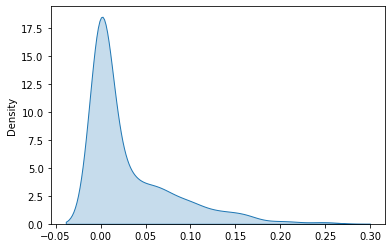

In [ ]:
sns.kdeplot(scores, shade=True)

In [ ]:
aux=scores>=0.10

In [ ]:
desc_ind_df = pd.DataFrame(x[x.columns[(aux)]])
user_descriptions_final = pd.concat([user_vectorized_descriptions[['user_id']], desc_ind_df], axis=1)
user_descriptions_final.head()

,user_id,feature_10,feature_11,feature_23,feature_30,feature_31,feature_56,feature_57,feature_63,feature_68,feature_73,feature_76,feature_77,feature_78,feature_96,feature_123,feature_126,feature_132,feature_133,feature_135,feature_177,feature_181,feature_184,feature_188,feature_204,feature_215,feature_242,feature_246,feature_252,feature_255,feature_256,feature_271,feature_292,feature_305,feature_318,feature_325,feature_356,feature_360,feature_373,feature_378,...,feature_384,feature_386,feature_390,feature_396,feature_399,feature_402,feature_437,feature_440,feature_452,feature_461,feature_468,feature_477,feature_479,feature_484,feature_485,feature_505,feature_509,feature_517,feature_521,feature_525,feature_569,feature_581,feature_583,feature_588,feature_615,feature_641,feature_657,feature_659,feature_662,feature_679,feature_684,feature_687,feature_693,feature_712,feature_726,feature_734,feature_740,feature_749,feature_765,feature_766
0,0,-0.211500,0.157389,-0.227588,0.063400,-0.129166,0.164060,-0.035821,-0.088360,0.048857,-0.127007,-0.151196,0.332261,-0.119579,-0.143582,-0.164984,0.107651,-0.024517,-0.248832,-0.310260,0.062425,-0.150958,0.163474,0.525133,-0.000080,0.144127,-0.245990,0.073195,-0.130701,0.000725,0.110455,0.216751,-0.103819,0.164987,0.015473,-0.229466,0.225990,0.258308,-0.138023,-0.186115,...,0.164156,-0.072401,0.067917,-0.170929,-0.479616,-0.134171,0.365890,0.062917,-0.242320,0.048156,-0.043080,-0.094013,0.030332,0.069932,-0.110668,0.168641,-0.089557,-0.020958,0.004820,-0.071652,0.257106,0.240818,-0.103563,-0.206351,0.295662,-0.189269,-0.074844,0.333497,-0.089876,-0.092021,0.067572,0.468707,0.113623,0.118463,-0.072149,0.027747,0.260563,-0.177539,-0.136515,-0.012882
1,1,-0.216736,0.183259,-0.216196,0.065532,-0.173314,0.177363,0.019470,-0.066750,0.113731,-0.240650,-0.140143,0.371227,-0.112252,-0.124035,-0.177170,0.027428,0.040057,-0.257099,-0.200916,0.054776,-0.143012,0.201250,0.565242,0.070893,0.138535,-0.159989,0.110166,-0.129033,0.106860,0.089767,0.167264,-0.045439,0.204276,-0.019951,-0.234419,0.220507,0.342663,-0.140962,-0.210006,...,0.232528,-0.012618,0.087887,-0.131857,-0.475033,-0.037448,0.366677,0.025165,-0.256038,0.132405,-0.094979,-0.069900,-0.023331,0.020398,-0.185518,0.097050,-0.036673,-0.044516,0.016589,-0.015872,0.264918,0.239811,-0.147890,-0.177510,0.292760,-0.161594,-0.059848,0.324165,-0.079116,-0.084849,0.019689,0.445625,0.156101,0.027914,-0.057515,-0.003619,0.246669,-0.211484,-0.143221,0.030484
2,2,-0.243968,0.184267,-0.207189,0.083048,-0.220785,0.226067,-0.028294,-0.088503,0.043957,-0.199157,-0.150104,0.391051,-0.089614,-0.208731,-0.140029,0.026959,-0.050508,-0.276596,-0.270453,0.038041,-0.065081,0.100557,0.525148,0.068653,0.135703,-0.170800,0.140348,-0.142160,0.068070,0.147560,0.180381,-0.079135,0.219635,-0.008464,-0.246029,0.190340,0.312025,-0.140601,-0.204175,...,0.156901,-0.035467,0.050221,-0.092760,-0.441471,-0.071977,0.367918,0.086504,-0.152118,0.117187,-0.076250,-0.052024,-0.010045,-0.001525,-0.179270,0.125107,-0.057964,-0.063851,0.010083,-0.094976,0.346696,0.262394,-0.108536,-0.196942,0.295341,-0.166838,-0.106664,0.314253,-0.138885,-0.020875,0.060327,0.499204,0.154727,0.124492,-0.054697,-0.024580,0.219368,-0.223201,-0.091951,0.025304
3,3,-0.206807,0.194023,-0.165441,0.049851,-0.122355,0.166001,-0.029035,-0.090611,0.097995,-0.233945,-0.048853,0.330243,-0.153693,-0.199100,-0.170986,0.110206,0.063167,-0.165298,-0.180626,-0.065528,-0.156289,0.219100,0.438837,0.057712,0.204902,-0.123685,0.194648,-0.137337,-0.020861,0.104912,0.243646,-0.118417,0.138946,0.004245,-0.263071,0.149715,0.366145,-0.085365,-0.219294,...,0.255399,-0.055750,-0.013577,-0.042278,-0.409406,-0.085178,0.269372,-0.030909,-0.076442,0.191220,-0.131733,-0.048732,0.066286,0.098000,-0.031447,0.043243,-0.146832,0.046408,-0.040442,-0.231770,0.331213,0.221374,-0.081669,-0.118138,0.251171,-0.065960,-0.078798,0.305377,-0.018127,-0.094924,0.079379,0.503873,0.141035,0.106728,-0.090472,-0.039165,0.232646,-0.193605,-0.180211,0.022327
4,4,-0

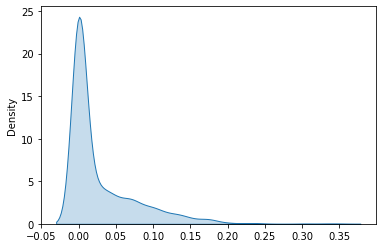

In [ ]:
y = profile_images_df['virality']
x = profile_images_df.loc[:, profile_images_df.columns.str.contains("feature_")] 

scores=mutual_info_classif(x, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=10)

sns.kdeplot(scores, shade=True)

A informação mútua para dados relativos à imagem de perfil foi a mais alta. Sugerindo que tais variáveis são mais significativas.

In [ ]:
aux=scores>=0.10
user_prof_ind_df = pd.DataFrame(x[x.columns[(aux)]])
user_profile_images_final = pd.concat([user_vectorized_profile_images[['user_id']], user_prof_ind_df], axis=1)
user_profile_images_final.head()

,user_id,feature_10,feature_11,feature_26,feature_50,feature_70,feature_79,feature_89,feature_98,feature_112,feature_113,feature_121,feature_147,feature_181,feature_185,feature_201,feature_204,feature_222,feature_235,feature_250,feature_258,feature_292,feature_306,feature_313,feature_318,feature_359,feature_368,feature_375,feature_379,feature_391,feature_395,feature_408,feature_414,feature_421,feature_422,feature_423,feature_425,feature_435,feature_437,feature_444,...,feature_1576,feature_1592,feature_1596,feature_1618,feature_1619,feature_1625,feature_1642,feature_1643,feature_1652,feature_1664,feature_1710,feature_1719,feature_1745,feature_1752,feature_1766,feature_1777,feature_1782,feature_1783,feature_1791,feature_1793,feature_1799,feature_1804,feature_1806,feature_1808,feature_1835,feature_1836,feature_1837,feature_1862,feature_1901,feature_1904,feature_1924,feature_1929,feature_1956,feature_1957,feature_1963,feature_1983,feature_2007,feature_2010,feature_2020,feature_2026
0,0,0.025731,0.464529,0.075417,0.000000,0.000000,0.037012,0.000000,0.002305,0.014284,0.189637,0.000000,0.893956,0.000000,0.055374,0.013746,0.171679,0.049177,0.000000,0.055681,0.000652,0.0,0.000000,0.001302,0.120090,0.000000,0.000000,0.677916,0.033984,0.379736,0.000000,0.020370,0.091552,0.000000,0.0,0.017272,0.204529,0.000000,0.000000,0.037355,...,0.000000,0.0,0.000000,0.00000,0.065150,0.219611,0.216745,0.000000,0.158610,0.000000,0.009356,0.219600,0.000000,0.000000,0.101736,0.016063,0.002076,0.000000,0.033612,0.411393,0.063463,0.295064,0.00000,0.406661,0.000000,0.010723,0.001276,0.066864,0.002762,0.00000,0.000000,0.00000,0.419271,0.018170,0.00353,0.000000,0.000639,0.000000,0.000000,0.000000
1,1,0.000000,0.297861,0.027106,0.000000,0.000000,0.000000,0.202877,0.000000,0.001523,0.013873,0.865496,0.004137,0.000000,0.175542,0.039580,0.107571,0.000000,0.151993,0.004418,0.349183,0.0,0.757251,0.000000,0.118413,0.011104,0.000000,0.513507,0.035213,0.062639,0.034684,0.180945,0.066106,0.000000,0.0,0.019612,0.049538,0.000000,0.000000,0.048692,...,0.000212,0.0,0.000000,0.00000,0.001450,0.013974,0.208784,0.038358,0.000000,0.007908,0.000000,0.008212,0.000000,0.059982,0.000000,0.200184,0.000000,0.000000,0.133920,0.025306,0.000217,0.377367,0.00000,0.002488,0.295841,0.059988,0.123035,0.000000,0.059634,0.00105,0.042417,0.00000,0.015664,0.741601,0.00000,0.000000,0.000000,0.000000,0.000000,0.034326
2,2,0.000000,0.520052,0.134256,0.170038,0.024927,0.140108,0.054947,0.238819,0.297307,0.483865,0.307469,0.357577,0.231542,0.044426,0.000000,0.001040,0.003554,0.462380,0.024212,0.243654,0.0,0.000000,0.000000,0.000000,0.018598,0.000000,0.000000,0.000000,0.000000,0.159570,0.723038,0.061270,0.000000,0.0,0.113177,0.001654,0.000000,0.000000,0.163285,...,0.029706,0.0,0.011086,0.00000,0.230595,0.154132,0.057343,0.173449,0.098698,0.000000,0.000000,0.005424,0.000372,0.033546,0.022407,0.024429,0.076472,0.042448,0.120005,0.000000,0.000000,0.018471,0.00000,0.113139,0.001617,0.014381,0.000000,0.000000,0.000000,0.00000,0.027794,0.00000,0.000000,0.001773,0.00396,0.050978,0.006636,0.038089,0.154669,0.000000
3,3,0.000000,0.377547,0.046941,0.000000,0.000000,0.227440,0.013525,0.000000,0.049761,0.917119,0.279236,0.000000,0.015089,0.000000,0.000624,0.000000,0.035186,0.000000,0.000000,0.002384,0.0,0.130022,0.000000,0.002858,0.004393,0.013725,0.101847,0.000000,0.000000,0.000277,0.231210,0.083874,0.081943,0.0,0.014146,0.108403,0.000000,0.000110,0.006661,...,0.000000,0.0,0.000000,0.16628,0.003493,0.074451,0.000000,0.000000,0.057827,0.000000,0.000000,0.105568,0.000000,0.091645,0.354691,0.248061,0.033564,0.000000,0.184952,0.106412,0.002328,0.000634,0.00000,0.001797,0.000000,0.222615,0.098403,0.000000,0.000000,0.00000,0.007177,0.00000,0.000000,0.000318,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.000000,0.130987,0.000000,0.000000,0.000000,0.376774,0.009404,0.036100,0.094855,0.243426,0.026234,0.642897,0.005557,0.000000,0.438231,0.216485,0.043259,0.000000,0.170169,0.000000,0.0,0.001327,0.000000,0.169

In [ ]:
print(train_tweets_final.shape)
print(train_tweets_media_final.shape) # join on tweet id
print(train_tweets_text_final.shape) # join on tweet id
print(users_final.shape) # join on user_id
print(user_profile_images_final.shape) # join on user_id

(29625, 173)
(21010, 197)
(29625, 24)
(52, 28)
(52, 190)


O código abaixo renomeia as colunas de train_tweets_text_final para evitar conflito na hora do merge.

In [ ]:
cols = train_tweets_text_final.columns[train_tweets_text_final.columns.str.contains('feature_')]
train_tweets_text_final.rename(columns = dict(zip(cols, 'text_' + cols)), inplace=True)
train_tweets_text_final.head()

,tweet_id,text_feature_102,text_feature_113,text_feature_142,text_feature_145,text_feature_207,text_feature_222,text_feature_227,text_feature_249,text_feature_280,text_feature_370,text_feature_418,text_feature_419,text_feature_473,text_feature_477,text_feature_574,text_feature_669,text_feature_677,text_feature_684,text_feature_723,text_feature_724,text_feature_736,text_feature_749,text_feature_751
0,0,-0.221726,0.136818,-0.061068,0.158193,-0.045862,-0.013509,-0.039967,-0.314939,-0.196727,0.188231,0.120291,0.028757,-0.036622,-0.133286,-0.107766,-0.050214,-0.059973,0.067214,0.083628,-0.087576,0.169754,-0.208796,-0.190645
1,1,-0.137403,0.135520,-0.014480,0.088869,0.044203,-0.037556,-0.154202,-0.265994,-0.149688,0.177193,0.135939,-0.031836,0.002674,-0.100656,-0.087606,0.024996,-0.071726,0.097758,0.051597,-0.016395,0.102271,-0.270230,-0.207080
2,4,-0.044526,0.102074,-0.074020,0.140882,-0.033880,-0.057548,-0.129431,-0.265982,-0.210003,0.115160,0.297382,-0.069542,0.039062,-0.049084,-0.132351,-0.028518,-0.010798,0.043780,-0.059980,0.028263,0.107764,-0.122995,-0.118704
3,5,-0.139881,0.227647,-0.053799,0.054213,-0.073003,-0.122609,-0.161668,-0.342098,-0.224708,0.125567,0.219644,-0.049488,0.070556,-0.092815,0.003130,0.042733,-0.054677,0.006685,-0.001471,-0.079780,0.155078,-0.184797,-0.136387
4,8,-0.185229,0.158385,-0.071673,0.178799,0.058510,-0.152557,-0.189969,-0.274310,-0.183501,0.120061,0.201681,-0.042512,0.044605,-0.140786,-0.007107,-0.016932,-0.128080,0.112383,0.006720,-0.019072,0.161351,-0.141493,-0.116183


Nem todos os tweets possuem mídia, e outros possuem mais de uma mídia, para lhe dar com isso, agrupamos os dados de mídia pelo id de cada tweet, e calculamos a média dos atributos de mídia. Para os tweets que não possuem mídia, os atributos foram preenchidos com zero.


In [ ]:
media_df = train_tweets_media_final.groupby('tweet_id').mean() #agrupa por idem e obtem a média dos dados de mídia
tweet_df = pd.merge(media_df, train_tweets_text_final, on = 'tweet_id', how = 'right') #junta os dados de mídia com os dados de texto
tweet_df.fillna(0, inplace=True) # preenche com zeros para os tweets que não tem mídia

# join users data
user_df = pd.merge(users_final, user_profile_images_final, on='user_id') #junta dados de descrição com dados de img de perfil

# join tweets data on train_tweets
tweet_df_final = pd.merge(train_tweets_final, tweet_df, on = 'tweet_id') #junta estatísticas do tweet com o restante dos dados de texto e imagem 

# join that with the users data
final_df = pd.merge(tweet_df_final, user_df, left_on = 'tweet_user_id', right_on='user_id')# junta com dados de usuário

final_df.shape # conjunto final tratado

(29625, 608)

In [ ]:
final_df.to_csv('dados_tweets_tratados.csv',index=False) #salva para não ter que rodar tudo denovo.

## Fit do Modelo

In [ ]:
path = r'gdrive/MyDrive/datasets/Dataset'

final_df = pd.read_csv(path + '/dados_tweets_tratados.csv') # salvamos o dataset para não ter 
                                                            # que rodar o código inteiro toda vez

In [ ]:
X = final_df.drop(['virality', 'tweet_user_id', 'tweet_id'], axis=1)
y = final_df['virality']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)
print('Training set shape ', X_train.shape)
print('Test set shape ', X_test.shape)

Training set shape  (20737, 605)
Test set shape  (8888, 605)


In [ ]:

clf = AdaBoostClassifier(n_estimators=50, learning_rate=1)
clf.fit(X_train, y_train)

pred=clf.predict(X_test)

acc=accuracy_score(pred,y_test)
acc

0.6185868586858686

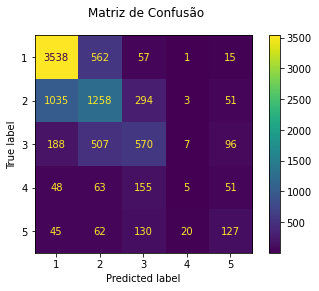

In [ ]:
fig=plot_confusion_matrix(clf, X_test, y_test, values_format='d')
fig.figure_.suptitle("Matriz de Confusão")
plt.show()




*   Nível 1: 84,72%
*   Nível 2: 47,63%
*   Nível 3: 41,67%
*   **Nível 4: 1,55%**
*   Nível 5: 33,07%





Nota-se que o modelo teve grande dificuldade em classificar o nível 4 corretamente, talvez por esse nível ser o menos presente no dataset.

Abaixo, um gráfico das distribuições dos pesos das variáveis. A maioria foi considerada irrelevante pelo Adaboost.

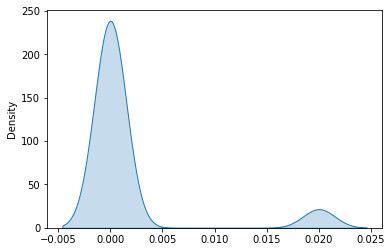

In [ ]:
importances=clf.feature_importances_
sns.kdeplot(importances, shade=True)

A maioria das variáveis teve peso zero, com algumas poucas consideradas levemente significantes.

## Tunning de Hiper-parâmetros

Todos os algoritmos de tuning foram feitos baseados em um RepeatedStratifiedKFold de 4 splits e 1 repetição.

Tuning da profundidade da árvore (individual).


>1 0.619 (0.009)
>2 0.604 (0.010)
>3 0.564 (0.010)


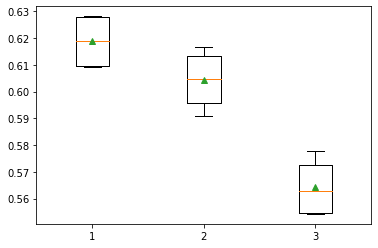

In [ ]:
def get_models():
	models = dict()
	# explore depths from 1 to 10
	for i in range(1,4):
		# define base model
		base = DecisionTreeClassifier(max_depth=i)
		# define ensemble model
		models[str(i)] = AdaBoostClassifier(base_estimator=base)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()   

O melhor desempenho foi com profundidade 1, o que é o padrão do Adaboost. Vamos então prosseguir para obter a melhor taxa de aprendizado; **alguns valores desse parâmetro já haviam sido testados e escolhemos o melhor intervalo.**


Por fim, vamos aplicar Grid Search para testar 24 combinações possíveis para o número de estimadores e taxa de aprendizado.

In [ ]:
model = AdaBoostClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [40,41,42,43,44,45,46,47]
grid['learning_rate'] = [.28,.3,.32,.34,.36, .38]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.638616 using {'learning_rate': 0.38, 'n_estimators': 47}
0.626869 (0.012934) with: {'learning_rate': 0.28, 'n_estimators': 40}
0.629907 (0.011054) with: {'learning_rate': 0.28, 'n_estimators': 41}
0.631730 (0.008074) with: {'learning_rate': 0.28, 'n_estimators': 42}
0.632641 (0.007223) with: {'learning_rate': 0.28, 'n_estimators': 43}
0.633451 (0.006437) with: {'learning_rate': 0.28, 'n_estimators': 44}
0.633418 (0.006625) with: {'learning_rate': 0.28, 'n_estimators': 45}
0.633620 (0.006582) with: {'learning_rate': 0.28, 'n_estimators': 46}
0.634498 (0.006347) with: {'learning_rate': 0.28, 'n_estimators': 47}
0.634093 (0.006193) with: {'learning_rate': 0.3, 'n_estimators': 40}
0.633451 (0.005401) with: {'learning_rate': 0.3, 'n_estimators': 41}
0.634700 (0.004190) with: {'learning_rate': 0.3, 'n_estimators': 42}
0.634937 (0.005053) with: {'learning_rate': 0.3, 'n_estimators': 43}
0.635544 (0.004973) with: {'learning_rate': 0.3, 'n_estimators': 44}
0.636523 (0.005922) with: {'le

## Resultados

O novo fitting com os melhores parâmetros será aplicado num conjunto diferente do utilizado para o tuning. Assim, podemos testar ainda mais a qualidade do modelo tunado.

In [ ]:
clf = AdaBoostClassifier(n_estimators=47, learning_rate=0.38)
clf.fit(X_train, y_train)

pred=clf.predict(X_test)

acc=accuracy_score(pred,y_test)
acc

0.6446894689468947

Há um ganho de 2,61 pontos percentuais ou 4,22%

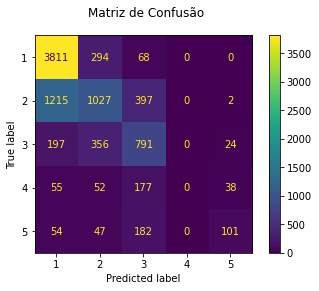

In [ ]:
fig=plot_confusion_matrix(clf, X_test, y_test, values_format='d')
fig.figure_.suptitle("Matriz de Confusão")
plt.show()

Nota-se um aumento na acurácia do nível 1 e 3 de viralidade. Os outros níveis perdem precisão, com destaque para o nível 5 que cai de 33% para 24,6%. Não houve predições para nível 4, erradas ou certas, a maioria dos tweets nível 4 foram preditos como 3.



In [ ]:
importances = clf.feature_importances_
importances = pd.Series(importances)
importances.index = X_test.columns
importances = importances.sort_values(ascending=False)

In [ ]:
importances[:5]

user_followers_count    0.063830
topic_id_87             0.042553
feature_1040            0.042553
feature_1277            0.021277
feature_808             0.021277
dtype: float64

O número de seguidores foi a variável mais impactante no modelo, o que já era esperado. Surpreendemente, um dos tópicos teve alta relevância, indicando que esse foi, muito provavelmente, um tópico viral.

Ainda no top 2, uma variável relativa à imagem de perfil também aparece.

In [ ]:
importances[importances.index.str.contains('user_')]

user_followers_count    0.063830
user_has_location       0.021277
user_following_count    0.021277
user_like_count         0.021277
user_tweet_count        0.000000
user_listed_on_count    0.000000
user_id                 0.000000
user_has_url            0.000000
dtype: float64

Em relação aos usuários, apenas o número de tweets do usuário e a quantidade de listas em que participa não foram consideradas relevantes.

In [ ]:
importances[importances.index.str.contains('topic_')].head()

topic_id_87    0.042553
topic_id_88    0.021277
topic_id_52    0.000000
topic_id_91    0.000000
topic_id_89    0.000000
dtype: float64

Apenas dois tópicos foram significativos.

In [ ]:
importances[importances.index.str.contains('tweet_')]

user_tweet_count        0.0
tweet_has_attachment    0.0
dtype: float64

In [ ]:
importances[importances.index.str.contains('atta')]

attatchment_A           0.0
attatchment_C           0.0
attatchment_B           0.0
tweet_has_attachment    0.0
dtype: float64

In [ ]:
importances[importances.index.str.contains('year')].head()

year_2013_y    0.021277
year_2015      0.021277
year_2020      0.000000
year_2013_x    0.000000
year_2014_x    0.000000
dtype: float64

Dois dummies de ano foram usados, um deles é do tweet e o outro da data de criação da conta.

Além disso, as quantidade de menções, hashtags e url's no tweets tiveram peso zero, assim como todos os dummies de idioma, dia do mês, hora do tweet e mês.

In [ ]:
(importances[importances.index.str.contains('img')] != 0).sum()

5

In [ ]:
(importances[importances.index.str.contains('text')] != 0).sum()

4

In [ ]:
(importances != 0).sum()

43

Das 605 variáveis fornecidas para a predição, apenas 43 foram utilizadas pelo modelo, das quais 5 eram de mídia, 4 de texto, 4 de dados de usuário, duas de tópico e mais duas de ano. As 26 restantes são relativas à descrição e imagem de perfil.

## Conclusão



Não alcançamos o desempenho de aproximadamente 66% do código de referência, a principal diferença é o método de feature selection e o estimador utilizado. As previsões sem tuning tiveram mais sucesso em classificar os tweets mais virais, com 33% de acurácia, isto é, previram corretamente 1 em cada 3 tweets de nível 5.

As previsões com tuning tiveram acurácia geral superior, impulsionada principalmente pelo nível 1 de viralidade. O modelo ideal depende do objetivo específico da previsão.

A grande maioria das variáveis tiverem peso nulo pelo Adaboost, mostrando que foram poucas as variáveis impactantes na viralidade dos tweets.

